<a href="https://colab.research.google.com/github/VEDgit2005/Covid-Probability-detector/blob/main/Textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating synthetic dataset...
Created synthetic dataset with 1000 samples
Train set: 600 samples
Validation set: 200 samples
Test set: 200 samples
Loading Universal Sentence Encoder...
Building model...
Training model...
Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4303 - loss: 0.6699 - val_accuracy: 0.4650 - val_loss: 0.5625
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4485 - loss: 0.5345 - val_accuracy: 0.6700 - val_loss: 0.4196
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7773 - loss: 0.3954 - val_accuracy: 0.9250 - val_loss: 0.3085
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9105 - loss: 0.3112 - val_accuracy: 0.9700 - val_loss: 0.2294
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9650 - loss: 0.2402 - val_accuracy: 0.9800 - val_loss: 0.1744
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9613 - loss: 0.1847 - val_accuracy: 0.9850 - val_loss: 0.1359
Epoch 7/10
19/1

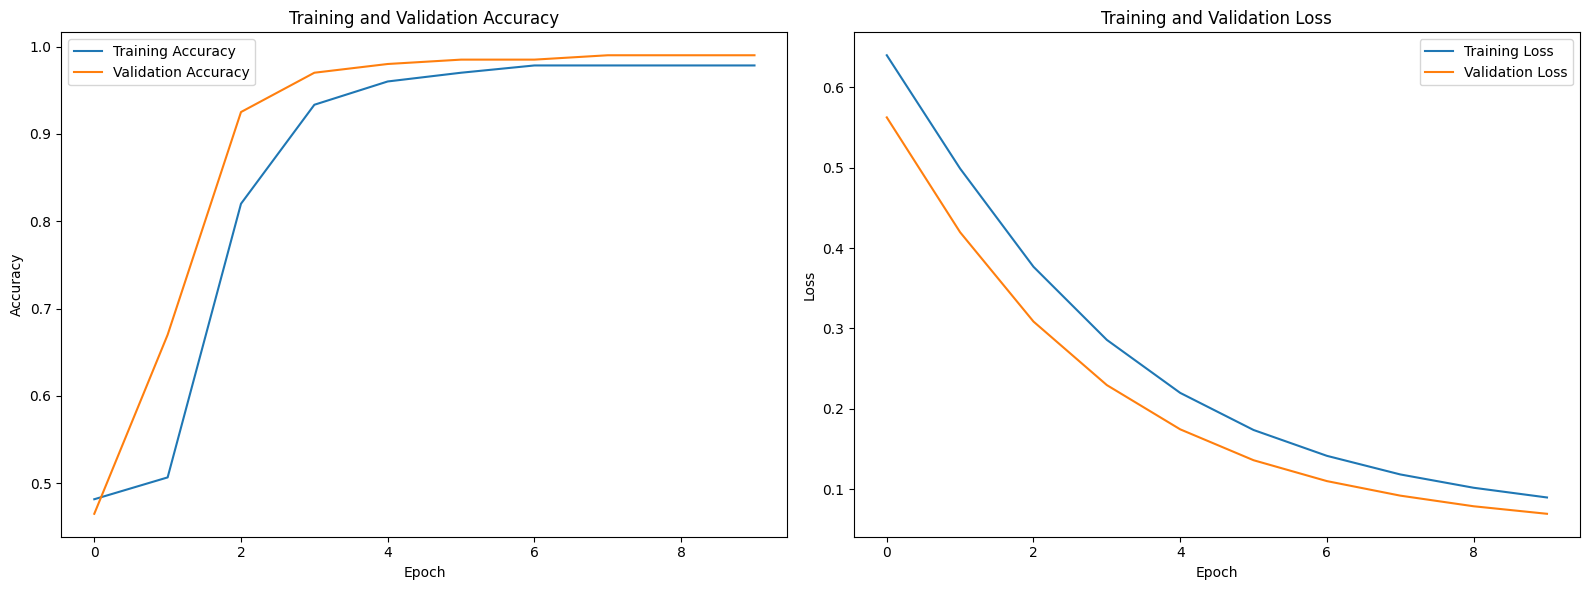


Testing model with example sentences:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Text: This product is amazing and I love it!
Sentiment: Positive
Confidence: 0.93

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Text: I'm really disappointed with this service.
Sentiment: Negative
Confidence: 0.05

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Text: The quality exceeded my expectations.
Sentiment: Negative
Confidence: 0.30

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: Would not recommend to anyone, terrible experience.
Sentiment: Negative
Confidence: 0.12



In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate a synthetic dataset
def create_synthetic_dataset(n_samples=1000):
    positive_phrases = ["good", "great", "excellent", "amazing", "love", "happy", "best", "perfect", "wonderful", "awesome"]
    negative_phrases = ["bad", "terrible", "awful", "horrible", "hate", "sad", "worst", "poor", "disappointing", "useless"]

    texts = []
    labels = []

    for _ in range(n_samples):
        # Choose sentiment
        sentiment = np.random.choice([0, 1])

        # Generate text based on sentiment
        if sentiment == 1:
            # Positive sentiment
            n_words = np.random.randint(5, 20)
            text = "I "
            for _ in range(n_words):
                if np.random.random() < 0.3:
                    text += np.random.choice(positive_phrases) + " "
                else:
                    text += np.random.choice(["the", "a", "this", "product", "is", "and", "very", "really", "quite", "so"]) + " "
        else:
            # Negative sentiment
            n_words = np.random.randint(5, 20)
            text = "I "
            for _ in range(n_words):
                if np.random.random() < 0.3:
                    text += np.random.choice(negative_phrases) + " "
                else:
                    text += np.random.choice(["the", "a", "this", "product", "is", "and", "very", "really", "quite", "so"]) + " "

        texts.append(text)
        labels.append(sentiment)

    # Create DataFrame
    df = pd.DataFrame({'text': texts, 'label': labels})
    print(f"Created synthetic dataset with {len(df)} samples")
    return df['text'].values, df['label'].values

# Generate dataset
print("Generating synthetic dataset...")
texts, labels = create_synthetic_dataset(1000)

# Split the dataset into training, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.4, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42)

print(f"Train set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")

# Convert to TensorFlow datasets
def create_dataset(texts, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 32
train_batches = create_dataset(train_texts, train_labels, batch_size).shuffle(10000)
validation_batches = create_dataset(val_texts, val_labels, batch_size)
test_batches = create_dataset(test_texts, test_labels, batch_size)

# Create custom model class to handle the TF Hub layer properly
print("Loading Universal Sentence Encoder...")
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"

class TextClassifier(tf.keras.Model):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.hub_layer = hub.KerasLayer(embedding, trainable=True)
        self.dense_1 = tf.keras.layers.Dense(16, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.hub_layer(inputs)
        x = self.dense_1(x)
        return self.dense_2(x)

# Initialize the model
print("Building model...")
model = TextClassifier()

# Build the model with a sample input
sample_text = tf.constant(['sample text'])
_ = model(sample_text)

# Compile model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
print("Training model...")
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=validation_batches,
    verbose=1
)

# Evaluate the model
print("Evaluating model...")
results = model.evaluate(test_batches, verbose=2)
for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

# Plot training history
plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model - FIXED LINE
model.save('sentiment_model.keras')

# Function to predict sentiment on new text
def predict_sentiment(text, model):
    predictions = model.predict(tf.constant([text]))
    score = tf.sigmoid(predictions[0])
    return "Positive" if score > 0.5 else "Negative", float(score)

# Example usage with some sample texts
test_examples = [
    "This product is amazing and I love it!",
    "I'm really disappointed with this service.",
    "The quality exceeded my expectations.",
    "Would not recommend to anyone, terrible experience."
]

print("\nTesting model with example sentences:")
for text in test_examples:
    sentiment, score = predict_sentiment(text, model)
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {score:.2f}")
    print()